In [423]:
# data collection from repository from bitbucket

!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [424]:
!ls german-traffic-signs/

signnames.csv  test.p  train.p	valid.p


In [425]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
import pickle
import pandas as pd
import random

In [426]:
np.random.seed(0)

In [427]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f) 
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f) 
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f) 

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [428]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [429]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the numbe rof labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the numbe rof labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the numbe rof labels"

assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32x32x3"
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32x32x3"
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32x32x3"

In [430]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

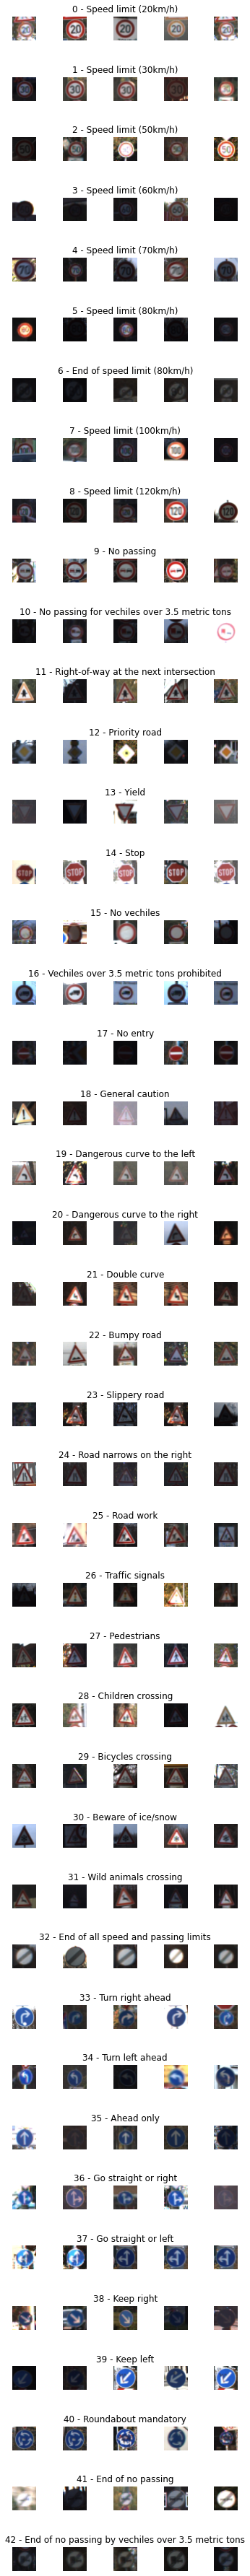

In [431]:
num_of_samples=[]
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
 
for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))


    

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


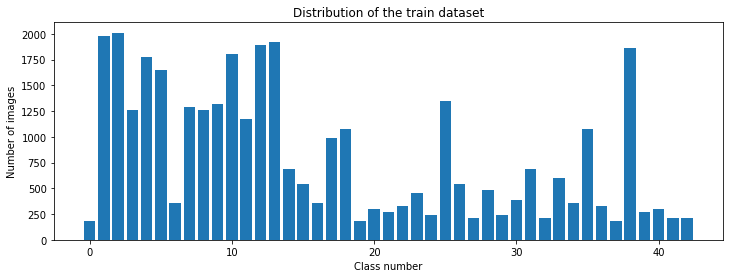

In [432]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


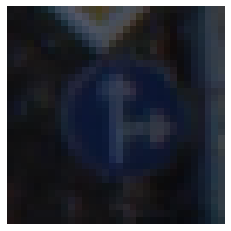

In [433]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


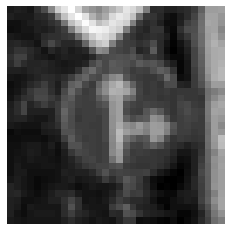

In [434]:
def grayscale(img):
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.axis("off")
print(img.shape)

(32, 32)


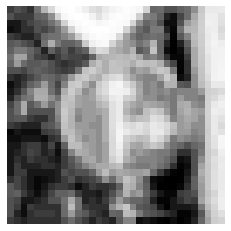

In [435]:
# histogram equaliztion --> to equalize the lighting

def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.axis("off")
print(img.shape)

In [436]:
# cinverts to grayscale and normalizing light intensity
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


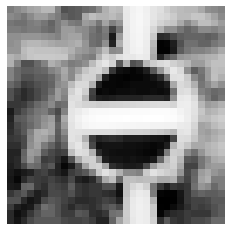

In [437]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)], cmap = plt.get_cmap('gray'))
plt.axis("off")
print(X_train.shape)

In [438]:
# adding depth to these images

X_train = X_train.reshape(34799, 32, 32, 1) 
X_test = X_test.reshape(12630, 32, 32, 1) 
X_val = X_val.reshape(4410, 32, 32, 1) 

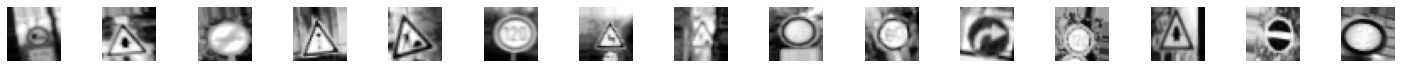

In [439]:
# data augumentation step --> using transformations on the existing images to increase size of data
# thsi adds variety to data

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1, 
                   height_shift_range = 0.1,
                   zoom_range = 0.2 ,
                   shear_range = 0.1,
                   rotation_range = 10.)

datagen.fit(X_train)

# calling datagen to create to images. 

batches = datagen.flow(X_train, y_train, batch_size =100)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1,15, figsize = (20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32), cmap = plt.get_cmap('gray'))
  axs[i].axis('off')

In [440]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [441]:
# one-hot encoding

y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [442]:
# designing the neural network.

def modified_model():
  model = Sequential()
  model.add(Conv2D(60,(5,5), input_shape = (32,32,1),activation='relu'))
  model.add(Conv2D(60,(5,5),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(30, (3,3),activation='relu'))
  model.add(Conv2D(30, (3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  #model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(500,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  #compile model
  model.compile(Adam(learning_rate=0.001),loss='categorical_crossentropy', metrics = ['accuracy'])
  return model

In [443]:
model = modified_model()
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 conv2d_53 (Conv2D)          (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 12, 12, 60)       0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_55 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 4, 4, 30)         0         
 g2D)                                                

In [444]:
## without augumented data
#history = model.fit(X_train, y_train, epochs = 10, validation_data=(X_val, y_val), batch_size = 1, verbose = 1, shuffle = 1)

## with augumented data
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch=600,
                            epochs=20,
                            validation_data=(X_val, y_val), shuffle = 1)


Epoch 1/20


<ipython-input-444-82e81361c70e>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),


600/600 [==============================] - 15s 24ms/step - loss: 1.9660 - accuracy: 0.4477 - val_loss: 0.4196 - val_accuracy: 0.8685
Epoch 2/20
600/600 [==============================] - 14s 23ms/step - loss: 0.6657 - accuracy: 0.7955 - val_loss: 0.2243 - val_accuracy: 0.9311
Epoch 3/20
600/600 [==============================] - 15s 26ms/step - loss: 0.3882 - accuracy: 0.8791 - val_loss: 0.1048 - val_accuracy: 0.9689
Epoch 4/20
600/600 [==============================] - 14s 23ms/step - loss: 0.2860 - accuracy: 0.9100 - val_loss: 0.0781 - val_accuracy: 0.9739
Epoch 5/20
600/600 [==============================] - 14s 23ms/step - loss: 0.2274 - accuracy: 0.9298 - val_loss: 0.0526 - val_accuracy: 0.9841
Epoch 6/20
600/600 [==============================] - 14s 23ms/step - loss: 0.1986 - accuracy: 0.9365 - val_loss: 0.0455 - val_accuracy: 0.9873
Epoch 7/20
600/600 [==============================] - 14s 23ms/step - loss: 0.1756 - accuracy: 0.9452 - val_loss: 0.0432 - val_accuracy: 0.9880
Epo

Text(0.5, 0, 'epoch')

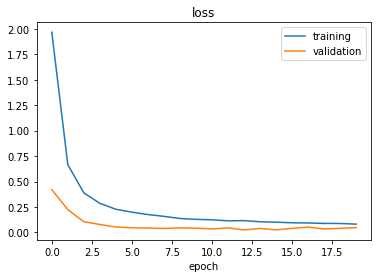

In [452]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

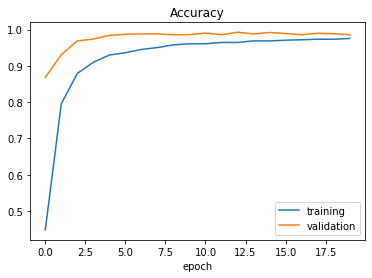

In [453]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [454]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])


Test Score: 0.12573513388633728
Test Accuracy: 0.9672209024429321


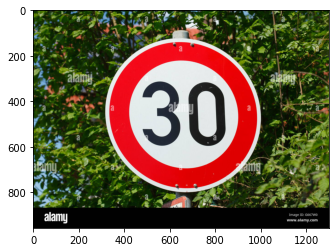

In [472]:
# real data testing

#fetch image
 
import requests
from PIL import Image
#url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
#url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
#url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
#url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'

r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


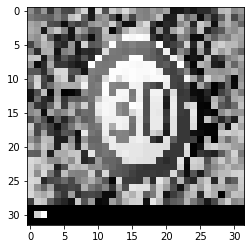

In [473]:
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [474]:
#Reshape reshape
img = img.reshape(1, 32, 32, 1)

In [475]:
#Test image
print("predicted sign: "+ str(np.argmax(model.predict(img), axis=-1)))

1/1 [==============================] - 0s 26ms/step
predicted sign: [1]
